In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
from collections import Counter

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.patches import PathPatch
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# ECG processing
import wfdb
import neurokit2 as nk
from neurokit2 import ecg

# Operating system and file manipulation
import os
import tkinter as tk
from tkinter import ttk

#Import custom module
from read_record import RecordReader, Record


In [2]:
def analyze_ecg(signal,sampling_freq):
    cleaned = nk.ecg_clean(signal, sampling_rate=sampling_freq)
    ecg, info=nk.ecg_process(cleaned)
    avg_heart_rate=np.mean(ecg['ECG_Rate'])
    return ecg,info,avg_heart_rate

In [3]:
def plot_signal_with_annotation(signal, annotation_symbols, 
                                annotation_indices, sampling_freq, 
                                ann_style='r.', figsize=(15,6)):
    
    #create time axis
    time=np.arange(len(signal))/sampling_freq
    pvc_percentage=100*(Counter(annotation_symbols)['V']/Counter(annotation_symbols)['N'])
    pac_percentage=100*(Counter(annotation_symbols)['A']/Counter(annotation_symbols)['N'])
    
    plt.figure(figsize=figsize)
    plt.plot(time,signal)
    plt.xlabel("Time(s)")
    plt.xlim(0,time[-1]) 
    plt.ylabel("Amplitube (mV)")
    
    plt.text(0.5, -0.23,f"PVC Percentage:{pvc_percentage:.2f} \nPAC Percentage:{pac_percentage:.2f}",
             transform=plt.gca().transAxes, ha='center',fontsize=12)
    
    
    for idx, symbol in zip(annotation_indices, annotation_symbols):
        plt.plot(idx/sampling_freq, signal[idx], ann_style)
        plt.annotate(symbol, (idx/sampling_freq, signal[idx]), xytext=(4,5), textcoords='offset pixels')
    
    plt.legend('')
    plt.show()

In [4]:
def choose_ecg_record(folder_path):
    """
    Allows the user to choose an ECG file from the specified folder.

    Args:
        folder_path (str): Path to the folder containing ECG files.

    Returns:
        str: Selected ECG file name (without extension).
    """
    
    # List all files in the specified folder
    files = os.listdir(folder_path)
    # Create a list of base filenames (without the '.hea' extension) for ECG signal files
    hea_files = [f[:-4] for f in files if f.endswith(".hea")]
    
    # Create the main window
    root = tk.Tk()
    root.title("Select the ECG record")
    
    # Dropdown menu
    clicked = tk.StringVar()
    clicked.set("Select an ECG file")
    drop = ttk.Combobox(root, textvariable=clicked, values=hea_files)
    drop.pack()
    
    # Type time range
    tk.Label(root, text="Enter time range (s):").pack()
    time_from = tk.Entry(root)
    time_from.pack()
    time_to = tk.Entry(root)
    time_to.pack()
    
    def show():
        selected_file = clicked.get()
        label.config(text=f"Selected ECG file: {selected_file}")
        
        record = wfdb.rdrecord(os.path.join(folder_path, selected_file))
        sampling_frequency = record.fs
        samp_from = sampling_frequency * int(time_from.get())
        samp_to = samp_from + (int(time_to.get()) * sampling_frequency)
        
        physical_signal = record.p_signal[int(samp_from):int(samp_to), 0]
        
        annotation = wfdb.rdann(os.path.join(folder_path, selected_file), 'atr',
                                  sampfrom=samp_from, sampto=samp_to, shift_samps=True)
        symbol = annotation.symbol
        indices = annotation.sample
        
        plot_signal_with_annotation(signal=physical_signal,
                                    annotation_symbols=symbol,
                                    annotation_indices=indices,
                                    sampling_freq=sampling_frequency,
                                    ann_style='r.', figsize=(15,6))
        
        
    
    # Button to display the selected file
    button = tk.Button(root, text="Show Selected File", command=show)
    button.pack()

    # Label to display the selected file
    label = tk.Label(root, text="")
    label.pack()

    root.mainloop()

In [5]:
folder_path = "D:/CPSC2021/Training_set_I"
record_name="data_1_7"
#choose_ecg_record(folder_path)

In [19]:
#Reading the record and the annotation of the record with custom module
reading_record=RecordReader.read(folder_path,record_name,0,0,None)


In [7]:
ecg,info,avg_hr=analyze_ecg(reading_record._Record__signal,reading_record._Record__sf)
print(f"The average heart rate of the Record {record_name} : {avg_hr:.2f}")

The average heart rate of the Record data_1_7 : 115.76


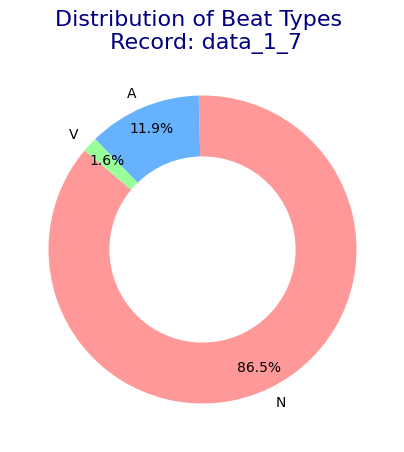

In [8]:
beat_counts = Counter(reading_record._Record__symbol)
labels = list(beat_counts.keys())
sizes = list(beat_counts.values())

# Soft pastel colors
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FFD700', '#FFB6C1', '#C2B280', '#FF6347', '#20B2AA', '#BA55D3']

fig, ax = plt.subplots(figsize=(5, 5))

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=colors)
ax.add_artist(plt.Circle((0, 0), 0.60, color='white'))  # Add a circle at the center to create a hole
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Distribution of Beat Types \n Record: {reading_record._Record__parent}', fontsize=16, color='navy')
plt.show()

By examining the pie chart, which includes annotations for arrhythmia types such as PAC (premature atrial contraction) at 11.9% and PVC (premature ventricular contraction) at 1.6%, it appears that this patient may be at risk of developing AF (atrial fibrillation) in the near future. Further analysis of this record, specifically assessing the PAC and PVC burden in each 30-second segment, is necessary.

In [9]:
ecg

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.015337,-0.018633,114.705475,0.984225,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-0.012266,-0.018499,114.705475,0.984225,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-0.009100,-0.018394,114.705475,0.984225,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-0.006198,-0.018324,114.705475,0.984225,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-0.003295,-0.018249,114.705475,0.984225,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584807,-0.005925,-0.003403,129.589633,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
584808,-0.006340,-0.003412,129.589633,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
584809,-0.007109,-0.003415,129.589633,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
584810,-0.008119,-0.003407,129.589633,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [11]:
print(f"The record duration is {reading_record.get_duration()} seconds long")
print(f"The record is labeled as {reading_record.get_label()}")
print(f"The record is sampled with {reading_record.get_sampling_frequency()} Hz")

The record duration is 2924.06 seconds long
The record is labeled as non atrial fibrillation
The record is sampled with 200 Hz


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,2615.393912,1256.48013,1077.926634,842.73987,1054.565828,900.042749,847.476637,917.516181,1297.352116,1297.933756,...,270.0,0.968496,2165.0,2620.0,61.324978,74.395703,1450.0,16485.0,27.243902,0.0


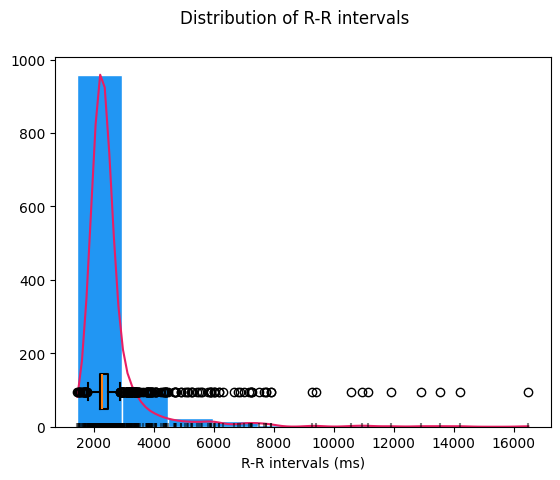

In [12]:
# Extract clean EDA and SCR features
hrv_time = nk.hrv_time(ecg, sampling_rate=200, show=True)
hrv_time

Heart rate variability (HRV) refers to the variation in time intervals between successive heartbeats, specifically the R-R intervals measured on an electrocardiogram (ECG). While a consistent rhythm (minimal HRV) may resemble a metronome, greater variability (higher HRV) indicates a more adaptable cardiovascular system. The above distribution of R-R intervals provides valuable insights. Notably, the peak around 2000 milliseconds (ms) suggests a dominant rhythm or variability pattern. 

In [13]:
# Automatically process the (raw) ECG signal
signals, info = nk.ecg_process(reading_record._Record__signal, sampling_rate=200)

In [14]:
# Extract clean ECG and R-peaks location
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = signals["ECG_Clean"]

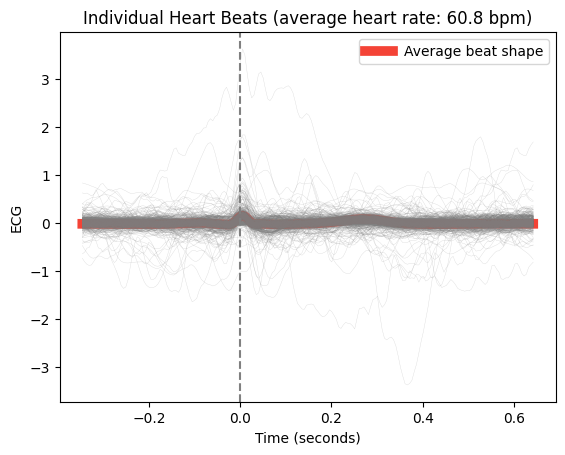

In [18]:
# Plotting all the heart beats
epochs = nk.ecg_segment(cleaned_ecg, rpeaks=rpeaks, sampling_rate=200, show=True)

From the plot above, it is observed that an average duration of approximately 0.8 seconds per epoch, corresponding to an average heart rate of 60.8 beats per minute. Additionally, the signals in this record exhibit noise, and there may be indications of arrhythmias in the patient. Furthermore, the amplitude of each epoch is around 0.5 mV, which should ideally be within the range of 1.5-2.5 mV. This discrepancy suggests that the patient may have faint heartbeats or might not be wearing the monitoring device properly.